In [8]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

### Preparing Dataset

In [9]:
words = open("names.txt", "r").read().splitlines()

In [10]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(stoi)
vocab_size

27

In [13]:


block_size = 3
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    
    for w in words:
    
        context = [0] * block_size
        for ch in w+".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
    
            context = context[1:]+[ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)   

    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

### Creating layers

In [12]:
g = torch.Generator().manual_seed(2147483647)

n_embed = 10
n_hidden = 200

C = torch.randn((27, n_embed), generator = g) #embedding matrix

W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)


W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, W2, b1, b2]

for p in parameters:
    p.requires_grad = True

print(f"num of parameters: {sum(p.nelement() for p in parameters)}")

num of parameters: 11897


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Xtr.to(device), Ytr.to(device)
for p in parameters:
    p.to(device)

In [16]:

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    h = torch.tanh(emb.view(-1, block_size * n_embed) @ W1 + b1)
    logits = h @ W2 + b2

    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
      


      0/ 200000: 26.7832
  10000/ 200000: 2.9658
  20000/ 200000: 2.2589
  30000/ 200000: 2.2723
  40000/ 200000: 2.1396
  50000/ 200000: 1.7821
  60000/ 200000: 2.2356
  70000/ 200000: 2.3465
  80000/ 200000: 1.9260
  90000/ 200000: 1.7438
 100000/ 200000: 2.5454
 110000/ 200000: 2.1703
 120000/ 200000: 2.6916
 130000/ 200000: 1.8312
 140000/ 200000: 1.8955
 150000/ 200000: 2.3153
 160000/ 200000: 1.7943
 170000/ 200000: 1.9758
 180000/ 200000: 2.4061
 190000/ 200000: 2.1174


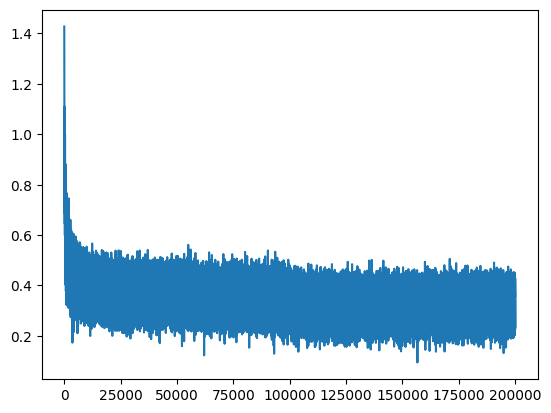

In [18]:
plt.plot(list(range(200000)), lossi)

### Evaluation

In [19]:
@torch.no_grad()
def split_loss(split):
    x, y = {
       "train" : (Xtr, Ytr),
        "test" : (Xte, Yte),
        "dev": (Xdev, Ydev)
    }[split] 
    emb = C[x]
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item()) 

split_loss("train")
split_loss("dev")

train 2.1158761978149414
dev 2.168163776397705


In [20]:
torch.cuda.empty_cache() 

### Sample from the model

In [30]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        prob = F.softmax(logits, dim=1)

        ix = torch.multinomial(prob, num_samples=1, generator = g)
        out.append(ix.item())
        context = context[1:]+[ix]

        if ix==0:
            break
    print(''.join(itos[i] for i in out))

mona.
mayah.
seel.
nihahaley.
thrus.
jarlei.
aderedielin.
emilopaleigh.
estanaraelynn.
hone.


### First Problem: Initialization

instead of starting from random distribution, we can start from a specific one because we can predict our loss => because each of the 27 letters has equal probability.

In [31]:
probOneLetter = 1/27.0

In [35]:
lossInitial = -torch.tensor([probOneLetter]).log()
lossInitial

tensor([3.2958])

this is much lower than our starting loss

In [37]:
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = F.softmax(logits, dim=0)
print(f"{probs=}")
loss = -probs[2].log()
print(f"{loss=}")

probs=tensor([0.2500, 0.2500, 0.2500, 0.2500])
loss=tensor(1.3863)


In [38]:
logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
probs = F.softmax(logits, dim=0)
print(f"{probs=}")
loss = -probs[2].log()
print(f"{loss=}")

probs=tensor([0.0066, 0.0066, 0.9802, 0.0066])
loss=tensor(0.0200)


In [39]:
logits = torch.tensor([0.0, 5.0, 0.0, 0.0])
probs = F.softmax(logits, dim=0)
print(f"{probs=}")
loss = -probs[2].log()
print(f"{loss=}")

probs=tensor([0.0066, 0.9802, 0.0066, 0.0066])
loss=tensor(5.0200)


In [40]:
logits = torch.tensor([-3.0, 5.0, 0.0, 2.0])
probs = F.softmax(logits, dim=0)
print(f"{probs=}")
loss = -probs[2].log()
print(f"{loss=}")

probs=tensor([3.1741e-04, 9.4620e-01, 6.3754e-03, 4.7108e-02])
loss=tensor(5.0553)


In [42]:
logits = torch.randn(4)
probs = F.softmax(logits, dim=0)
print(f"{probs=}")
loss = -probs[2].log()
print(f"{loss=}")
print(f"{logits=}")

probs=tensor([0.6503, 0.0434, 0.1308, 0.1755])
loss=tensor(2.0339)
logits=tensor([ 0.9438, -1.7630, -0.6597, -0.3661])


Extreme values will produce higher loss. May even produce inf

In [43]:
logits = torch.randn(4) *10
probs = F.softmax(logits, dim=0)
print(f"{probs=}")
loss = -probs[2].log()
print(f"{loss=}")
print(f"{logits=}")

probs=tensor([4.5005e-12, 2.0077e-13, 3.5192e-03, 9.9648e-01])
loss=tensor(5.6495)
logits=tensor([-12.1436, -15.2534,   8.3337,  13.9797])


In [44]:
logits = torch.randn(4) *100
probs = F.softmax(logits, dim=0)
print(f"{probs=}")
loss = -probs[2].log()
print(f"{loss=}")
print(f"{logits=}")

probs=tensor([9.9961e-01, 7.5035e-27, 0.0000e+00, 3.9313e-04])
loss=tensor(inf)
logits=tensor([  94.7214,   34.5674, -194.5307,   86.8804])


loss will be less if logits are equals or all zeros

#### Rerun the loop

In [45]:
g = torch.Generator().manual_seed(2147483647)

n_embed = 10
n_hidden = 200

C = torch.randn((27, n_embed), generator = g) #embedding matrix

W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)


W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, W2, b1, b2]

for p in parameters:
    p.requires_grad = True

print(f"num of parameters: {sum(p.nelement() for p in parameters)}")

num of parameters: 11897


In [46]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    h = torch.tanh(emb.view(-1, block_size * n_embed) @ W1 + b1)
    logits = h @ W2 + b2

    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break #we only want initial loss

      0/ 200000: 24.0617


Lets make b2 as 0 and multiply a small number to W2

In [47]:
g = torch.Generator().manual_seed(2147483647)

n_embed = 10
n_hidden = 200

C = torch.randn((27, n_embed), generator = g) #embedding matrix

W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)


W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, W2, b1, b2]

for p in parameters:
    p.requires_grad = True

print(f"num of parameters: {sum(p.nelement() for p in parameters)}")

num of parameters: 11897


In [48]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    h = torch.tanh(emb.view(-1, block_size * n_embed) @ W1 + b1)
    logits = h @ W2 + b2

    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break #we only want initial loss

      0/ 200000: 3.2982


Let's keep this setting and run the model

#### Rerun the model at new setting

In [6]:
g = torch.Generator().manual_seed(2147483647)

n_embed = 10
n_hidden = 200

C = torch.randn((27, n_embed), generator = g) #embedding matrix

W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)


W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, W2, b1, b2]

for p in parameters:
    p.requires_grad = True

print(f"num of parameters: {sum(p.nelement() for p in parameters)}")

num of parameters: 11897


In [7]:
Xtr.is_cuda

False

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Xtr.to(device), Ytr.to(device)
for p in parameters:
    p.to(device)

In [9]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    h = torch.tanh(emb.view(-1, block_size * n_embed) @ W1 + b1)
    logits = h @ W2 + b2

    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2928
  10000/ 200000: 2.3158
  20000/ 200000: 2.5892
  30000/ 200000: 2.2148
  40000/ 200000: 1.9304
  50000/ 200000: 2.1316
  60000/ 200000: 2.4017
  70000/ 200000: 2.2869
  80000/ 200000: 2.4929
  90000/ 200000: 2.2804
 100000/ 200000: 1.8168
 110000/ 200000: 2.4273
 120000/ 200000: 2.2647
 130000/ 200000: 2.3374
 140000/ 200000: 2.0427
 150000/ 200000: 1.6251
 160000/ 200000: 2.0266
 170000/ 200000: 2.3210
 180000/ 200000: 2.1497
 190000/ 200000: 2.2820


In [10]:
@torch.no_grad()
def split_loss(split):
    x, y = {
       "train" : (Xtr, Ytr),
        "test" : (Xte, Yte),
        "dev": (Xdev, Ydev)
    }[split] 
    emb = C[x]
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item()) 

split_loss("train")
split_loss("dev")

train 2.068723201751709
dev 2.12954044342041


In [11]:
torch.cuda.empty_cache() 

This result is much better than the previous 2.17 dev loss. Reason is we are spending more time to train the nn rather than to squash down the weights that were previously random.

### 2nd Problem: Issue with h

In [12]:
g = torch.Generator().manual_seed(2147483647)

n_embed = 10
n_hidden = 200

C = torch.randn((27, n_embed), generator = g) #embedding matrix

W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)


W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, W2, b1, b2]

for p in parameters:
    p.requires_grad = True

print(f"num of parameters: {sum(p.nelement() for p in parameters)}")

num of parameters: 11897


In [13]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    h = torch.tanh(emb.view(-1, block_size * n_embed) @ W1 + b1)
    logits = h @ W2 + b2

    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.3167


In [14]:
h

tensor([[-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        ...,
        [ 0.9877, -0.9999,  0.9916,  ...,  0.9767, -1.0000, -0.9991],
        [ 1.0000, -1.0000,  0.9950,  ...,  0.9999, -1.0000, -1.0000],
        [-0.7953, -0.1111,  0.9982,  ..., -1.0000,  0.9273,  1.0000]],
       grad_fn=<TanhBackward0>)

h has a lots of 1 and -1

In [15]:
h.view(-1).shape

torch.Size([6400])

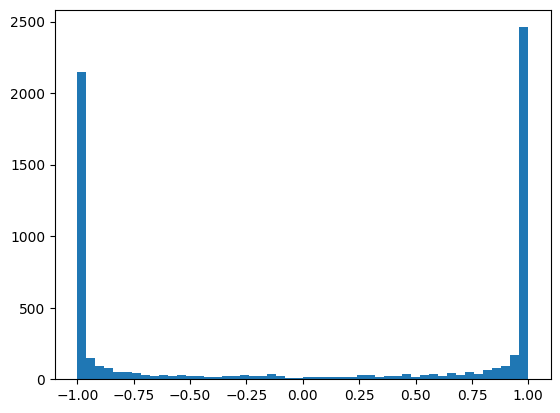

In [18]:
plt.hist(h.view(-1).tolist(), 50);

check the pre activations

(array([  1.,   1.,   0.,   3.,   4.,   3.,   0.,  14.,   8.,  21.,  20.,
         32.,  68.,  66.,  80., 131., 186., 196., 253., 238., 316., 322.,
        377., 399., 396., 415., 422., 369., 383., 350., 268., 249., 171.,
        135., 159.,  96.,  82.,  50.,  38.,  22.,  21.,  11.,  10.,   8.,
          2.,   1.,   1.,   0.,   1.,   1.]),
 array([-21.45806694, -20.58893295, -19.71979897, -18.85066498,
        -17.98153099, -17.112397  , -16.24326302, -15.37412903,
        -14.50499504, -13.63586105, -12.76672707, -11.89759308,
        -11.02845909, -10.1593251 ,  -9.29019112,  -8.42105713,
         -7.55192314,  -6.68278915,  -5.81365517,  -4.94452118,
         -4.07538719,  -3.2062532 ,  -2.33711922,  -1.46798523,
         -0.59885124,   0.27028275,   1.13941673,   2.00855072,
          2.87768471,   3.7468187 ,   4.61595268,   5.48508667,
          6.35422066,   7.22335464,   8.09248863,   8.96162262,
          9.83075661,  10.69989059,  11.56902458,  12.43815857,
         13.307292

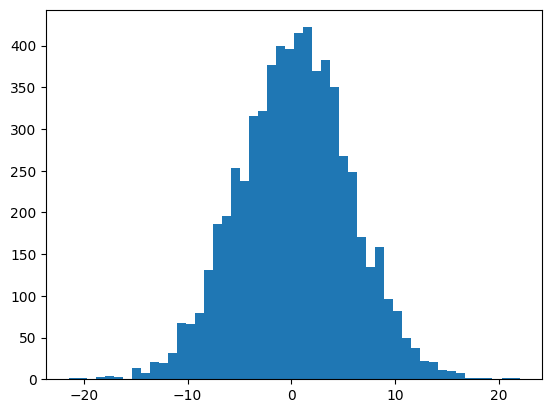

In [20]:
hpreact = emb.view(-1, block_size * n_embed) @ W1 + b1
plt.hist(hpreact.view(-1).tolist(), 50)

if the points are near the flat region of tanh, the gradient will be 0 (derivative (1-tanh**2) and tanh is mostly 1,-1). 

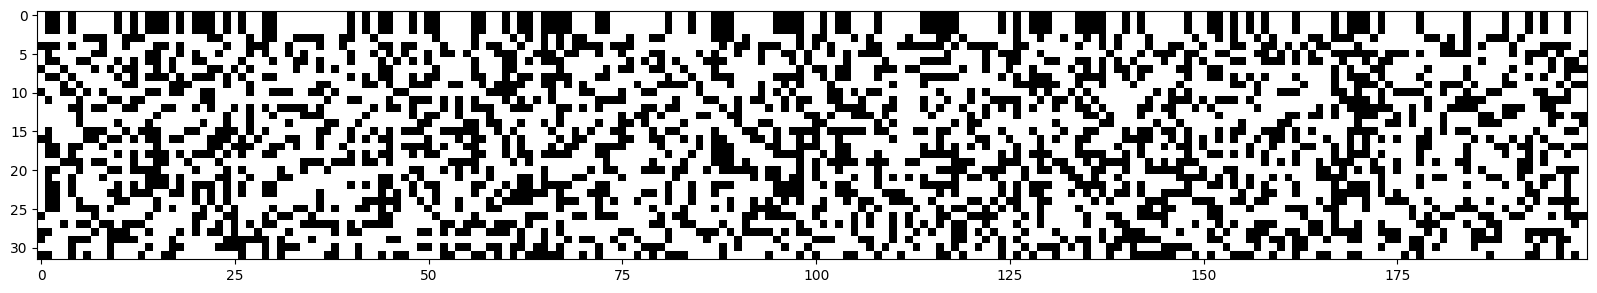

In [21]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap="gray", interpolation="nearest")

y axis corresponds to 200 hidden layers. Most white (ie value 1) means most are on the flat region of tanh. But there is no white vertical line. If there were a vertical line it would represent a dead neuron ie the neuron wheren grad is always 0.


hpreact is causing the issue because it is very far off from zero. It needs to be brought closer to zero. let's multiply W1 by 0.1

In [22]:
g = torch.Generator().manual_seed(2147483647)

n_embed = 10
n_hidden = 200

C = torch.randn((27, n_embed), generator = g) #embedding matrix

W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden, generator=g) * 0.01


W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, W2, b1, b2]

for p in parameters:
    p.requires_grad = True

print(f"num of parameters: {sum(p.nelement() for p in parameters)}")

num of parameters: 11897


In [23]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    h = torch.tanh(emb.view(-1, block_size * n_embed) @ W1 + b1)
    logits = h @ W2 + b2

    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.3136


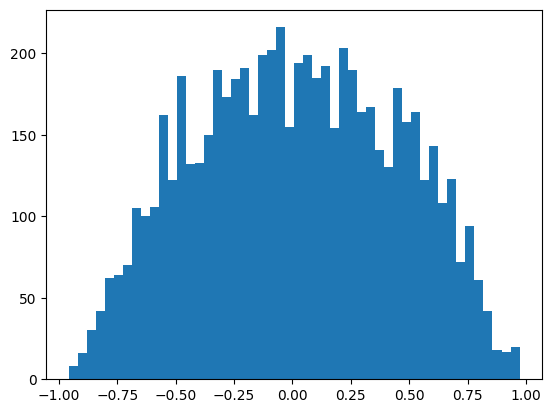

In [26]:

plt.hist(h.view(-1).tolist(), 50);

(array([  2.,   2.,   2.,   1.,   5.,   6.,  12.,  13.,  24.,  31.,  52.,
         58.,  64., 114., 123., 173., 213., 277., 244., 319., 371., 371.,
        413., 385., 390., 378., 359., 338., 262., 268., 266., 173., 185.,
        127.,  90.,  94.,  57.,  44.,  31.,  11.,   9.,  11.,   5.,   4.,
         12.,   3.,   3.,   2.,   1.,   2.]),
 array([-1.91677749, -1.83571437, -1.75465125, -1.67358813, -1.59252501,
        -1.51146189, -1.43039877, -1.34933565, -1.26827253, -1.18720941,
        -1.10614629, -1.02508317, -0.94402005, -0.86295693, -0.78189381,
        -0.70083069, -0.61976757, -0.53870445, -0.45764132, -0.3765782 ,
        -0.29551508, -0.21445196, -0.13338884, -0.05232572,  0.0287374 ,
         0.10980052,  0.19086364,  0.27192676,  0.35298988,  0.434053  ,
         0.51511612,  0.59617924,  0.67724236,  0.75830548,  0.8393686 ,
         0.92043172,  1.00149484,  1.08255796,  1.16362108,  1.2446842 ,
         1.32574732,  1.40681044,  1.48787356,  1.56893668,  1.6499998 ,
 

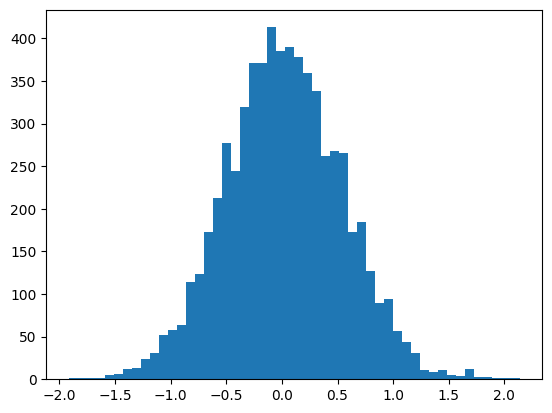

In [24]:
hpreact = emb.view(-1, block_size * n_embed) @ W1 + b1
plt.hist(hpreact.view(-1).tolist(), 50)

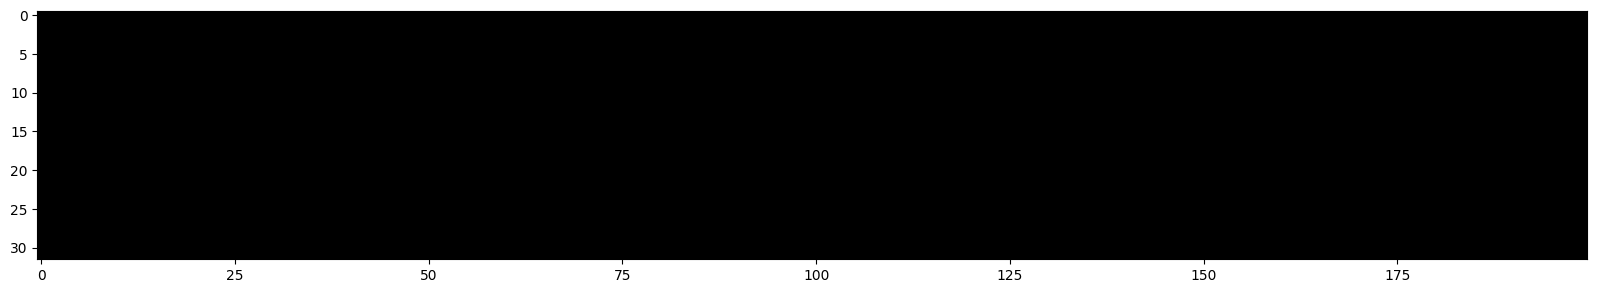

In [25]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap="gray", interpolation="nearest")

no neurons saturated at -1,1.
but might be better if W1 is multiplied with 0.2 rather than with 0.1

In [27]:
g = torch.Generator().manual_seed(2147483647)

n_embed = 10
n_hidden = 200

C = torch.randn((27, n_embed), generator = g) #embedding matrix

W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01


W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, W2, b1, b2]

for p in parameters:
    p.requires_grad = True

print(f"num of parameters: {sum(p.nelement() for p in parameters)}")

num of parameters: 11897


In [29]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    h = torch.tanh(emb.view(-1, block_size * n_embed) @ W1 + b1)
    logits = h @ W2 + b2

    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.3026


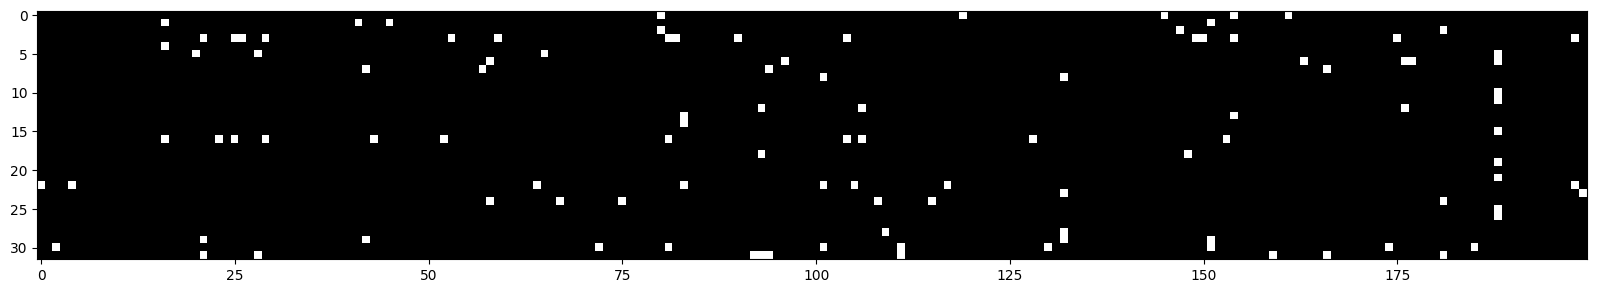

In [30]:

plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap="gray", interpolation="nearest")

Run the full optimization

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Xtr.to(device), Ytr.to(device)
for p in parameters:
    p.to(device)

In [34]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    h = torch.tanh(emb.view(-1, block_size * n_embed) @ W1 + b1)
    logits = h @ W2 + b2

    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2081
  10000/ 200000: 2.2939
  20000/ 200000: 2.6292
  30000/ 200000: 1.5742
  40000/ 200000: 2.3389
  50000/ 200000: 2.1643
  60000/ 200000: 2.6583
  70000/ 200000: 2.2245
  80000/ 200000: 1.6620
  90000/ 200000: 1.9746
 100000/ 200000: 1.9621
 110000/ 200000: 2.2002
 120000/ 200000: 1.6428
 130000/ 200000: 2.2990
 140000/ 200000: 2.0787
 150000/ 200000: 2.0834
 160000/ 200000: 1.9017
 170000/ 200000: 1.8190
 180000/ 200000: 2.1743
 190000/ 200000: 2.0982


In [35]:
@torch.no_grad()
def split_loss(split):
    x, y = {
       "train" : (Xtr, Ytr),
        "test" : (Xte, Yte),
        "dev": (Xdev, Ydev)
    }[split] 
    emb = C[x]
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item()) 

split_loss("train")
split_loss("dev")

train 2.038377046585083
dev 2.1042044162750244


### Defining init scale: kaiming init

tensor(0.0022) tensor(1.0028)
tensor(-0.0011) tensor(3.1763)


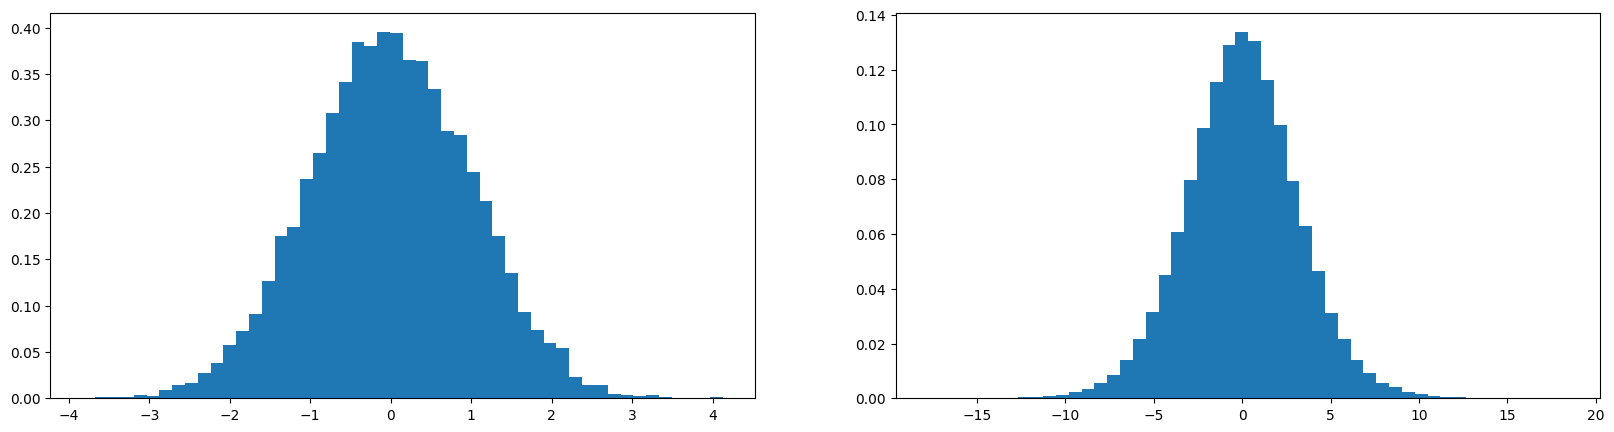

In [41]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)

y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), bins=50, density=True);


plt.subplot(122)
plt.hist(y.view(-1).tolist(), bins=50, density=True);

ideal would be to keep the std of both to 1. so we need to multiply x distribution with a small number.

tensor(-0.0062) tensor(0.9905)
tensor(0.0004) tensor(0.3206)


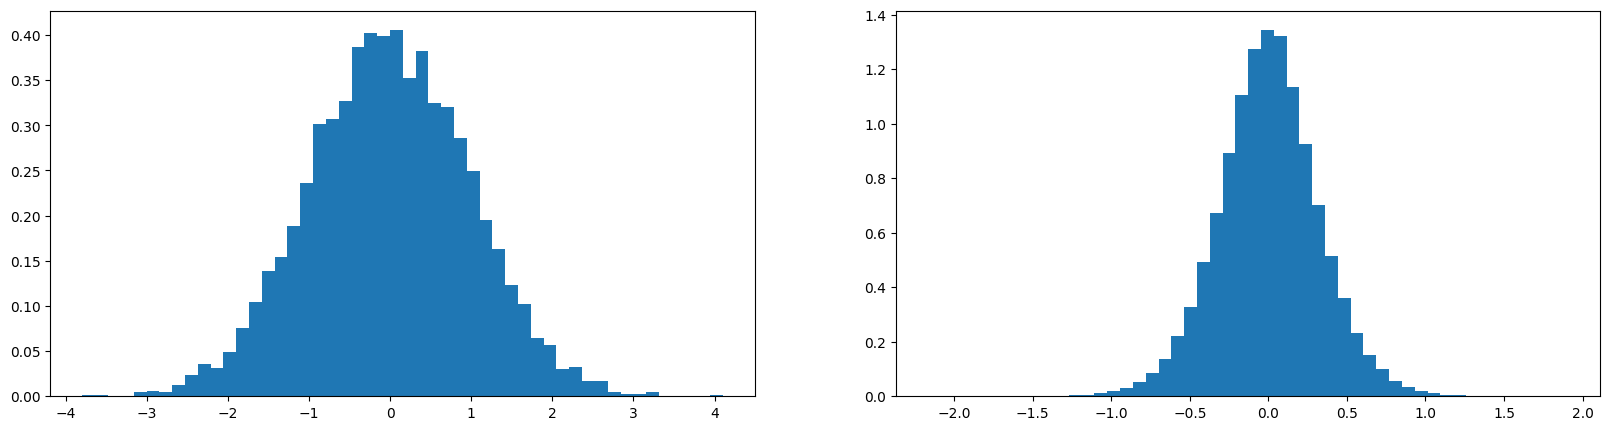

In [42]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * 0.1

y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), bins=50, density=True);


plt.subplot(122)
plt.hist(y.view(-1).tolist(), bins=50, density=True);

https://math.stackexchange.com/questions/3170393/standard-deviation-of-product-of-two-gaussian-distribution

to normalize the gaussian which is a product of two other gaussians

tensor(0.0007) tensor(0.9938)
tensor(0.0007) tensor(1.0012)


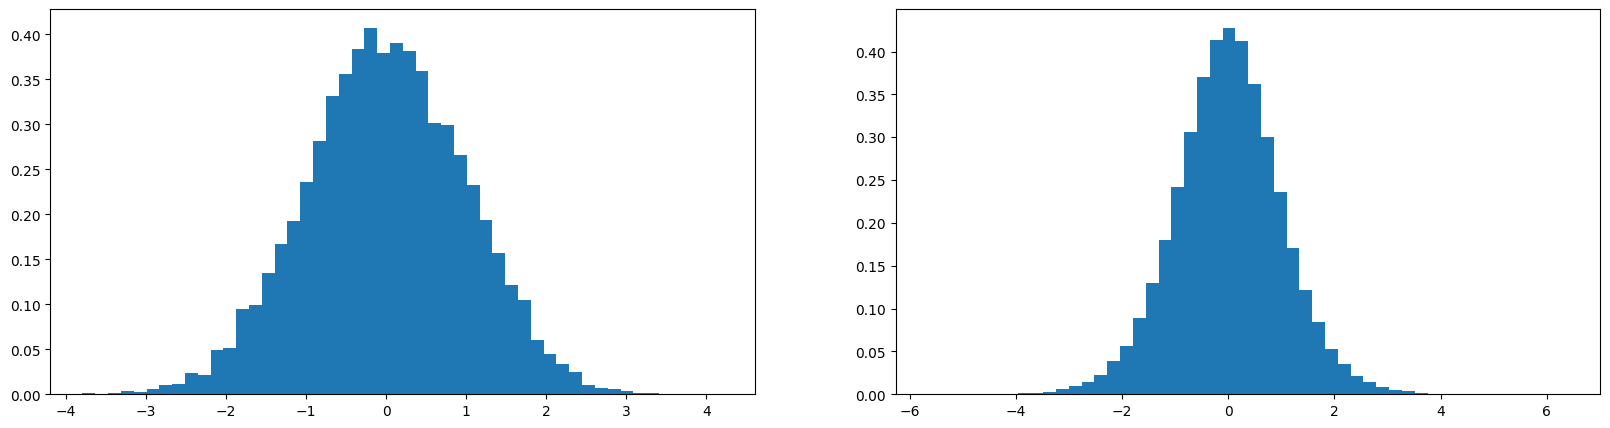

In [45]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * 10**(-0.5)

y = x @w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), bins=50, density=True);


plt.subplot(122)
plt.hist(y.view(-1).tolist(), bins=50, density=True);

https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_

A factor need to be multiplied to gaussian weights of the nn which is gain/sqrt(fan in). for tanh, gain = 5/3

In [13]:
g = torch.Generator().manual_seed(2147483647)

n_embed = 10
n_hidden = 200

C = torch.randn((27, n_embed), generator = g) #embedding matrix

W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3) / (n_embed * block_size)**0.5
b1 = torch.randn(n_hidden, generator=g) * 0.01


W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, W2, b1, b2]

for p in parameters:
    p.requires_grad = True

print(f"num of parameters: {sum(p.nelement() for p in parameters)}")

num of parameters: 11897


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device="cpu"
Xtr = Xtr.to(device)
Ytr= Ytr.to(device)
# for p in parameters:
#     p = p.to(device)
C = C.to(device)

W1 = W1.to(device)
W2 = W2.to(device)

b1 = b1.to(device)
b2 = b2.to(device)

In [16]:
%%time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embact = emb.view(-1, block_size * n_embed)
    hpreact = embact @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2

    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3279
  10000/ 200000: 1.9742
  20000/ 200000: 1.9860
  30000/ 200000: 1.9473
  40000/ 200000: 2.0718
  50000/ 200000: 1.9087
  60000/ 200000: 2.1487
  70000/ 200000: 1.8424
  80000/ 200000: 2.3512
  90000/ 200000: 2.3963
 100000/ 200000: 1.7392
 110000/ 200000: 2.0752
 120000/ 200000: 2.2780
 130000/ 200000: 2.2498
 140000/ 200000: 2.2646
 150000/ 200000: 2.0655
 160000/ 200000: 2.3440
 170000/ 200000: 2.0081
 180000/ 200000: 2.1473
 190000/ 200000: 2.2576
CPU times: user 8min 56s, sys: 3.51 s, total: 8min 59s
Wall time: 1min 35s


#### Training with GPU

In [5]:
g = torch.Generator().manual_seed(2147483647)

n_embed = 10
n_hidden = 200

C = torch.randn((27, n_embed), generator = g) #embedding matrix

W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3) / (n_embed * block_size)**0.5
b1 = torch.randn(n_hidden, generator=g) * 0.01


W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, W2, b1, b2]

for p in parameters:
    p.requires_grad = True

print(f"num of parameters: {sum(p.nelement() for p in parameters)}")

num of parameters: 11897


In [6]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Xtr = Xtr.to(device)
# Ytr= Ytr.to(device)
# # for p in parameters:
# #     p = p.to(device)
# C = C.to(device)

# W1 = W1.to(device)
# W2 = W2.to(device)

# b1 = b1.to(device)
# b2 = b2.to(device)

In [ ]:
%%time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embact = emb.view(-1, block_size * n_embed)
    hpreact = embact @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2

    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2870
  10000/ 200000: 3.3197


In [31]:
torch.cuda.empty_cache() 

In [10]:
@torch.no_grad()
def split_loss(split):
    x, y = {
       "train" : (Xtr, Ytr),
        "test" : (Xte, Yte),
        "dev": (Xdev, Ydev)
    }[split] 
    emb = C[x]
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item()) 

split_loss("train")
split_loss("dev")

train 2.037274122238159
dev 2.1074886322021484


hpreact should be gaussian with 0 mean and 1 std => so that they are not too large or not too small to be killed by tanh.

it can be normalized into N(0,1)=> just normalize the hidden state =>batch normalization.

but it should be gaussian only at initialization. at other cases the the gaussian should be allowed to be expanded+moved around so that the loss is the minimum


### Batch normalization

In [48]:
hpreact.shape #(batch size, hidden layer)

torch.Size([32, 200])

In [36]:
#mean across batches
hpreact.mean(dim=0, keepdim=True).shape

torch.Size([1, 200])

In [37]:
hpreact.std(dim=0, keepdim=True).shape

torch.Size([1, 200])

In [47]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    ix = ix.to(device)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embact = emb.view(-1, block_size * n_embed)
    hpreact = embact @ W1 + b1

    #Normalize the batches
    epsilon = 1e-5
    # mean = hpreact.mean(dim=0, keepdims=True).to(device)
    # std = hpreact.std(dim=0, keepdim=True).to(device)

    hpreact = (hpreact - hpreact.mean(dim=0, keepdims=True))/(hpreact.std(dim=0, keepdim=True).to(device) + epsilon)
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2

    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2868
  10000/ 200000: 3.3256
  20000/ 200000: 3.2949
  30000/ 200000: 3.3291
  40000/ 200000: 3.2826
  50000/ 200000: 3.2988
  60000/ 200000: 3.2851
  70000/ 200000: 3.3352
  80000/ 200000: 3.3030
  90000/ 200000: 3.3030
 100000/ 200000: 3.2990
 110000/ 200000: 3.3181
 120000/ 200000: 3.2950
 130000/ 200000: 3.3220
 140000/ 200000: 3.3031
 150000/ 200000: 3.3262
 160000/ 200000: 3.2986
 170000/ 200000: 3.2822
 180000/ 200000: 3.2830
 190000/ 200000: 3.3059


Performance degraded because it was initialised at every iteration. but we want to initialize only at first and then the model will deicde. so we want learnable parameters to help the gaussian move freely as the model wish

In [32]:
g = torch.Generator().manual_seed(2147483647)

n_embed = 10
n_hidden = 200

C = torch.randn((27, n_embed), generator = g) #embedding matrix

W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3) / (n_embed * block_size)**0.5
b1 = torch.randn(n_hidden, generator=g) * 0.01

#Batch normalization parameters
#one for each hidden layer
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))


W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

# parameters = [C, W1, W2, b1, b2]
parameters = [C, W1, W2, b1, b2] #bn params must be added

for p in parameters:
    p.requires_grad = True

print(f"num of parameters: {sum(p.nelement() for p in parameters)}")

num of parameters: 11897


In [33]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Xtr = Xtr.to(device)
# Ytr= Ytr.to(device)

# C = C.to(device)

# W1 = W1.to(device)
# W2 = W2.to(device)

# bngain = bngain.to(device)
# bnbias = bnbias.to(device)

# b1 = b1.to(device)
# b2 = b2.to(device)

In [34]:
%%time

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embact = emb.view(-1, block_size * n_embed)
    hpreact = embact @ W1 + b1

    #Normalize the batches
    epsilon = 1e-5
    mean = hpreact.mean(dim=0, keepdims=True)
    std = hpreact.std(dim=0, keepdim=True)

    hpreact = (hpreact - mean)/(std + epsilon) 
    # hpreact = bngain * (hpreact - mean)/std + bnbias
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2

    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3217
  10000/ 200000: 2.1949
  20000/ 200000: 2.0421
  30000/ 200000: 2.1342
  40000/ 200000: 2.1259
  50000/ 200000: 2.2033
  60000/ 200000: 2.4894
  70000/ 200000: 2.3485
  80000/ 200000: 2.5252
  90000/ 200000: 2.1278
 100000/ 200000: 1.8137
 110000/ 200000: 2.0090
 120000/ 200000: 1.8853
 130000/ 200000: 1.9639
 140000/ 200000: 2.0212
 150000/ 200000: 2.1426
 160000/ 200000: 2.6622
 170000/ 200000: 2.5909
 180000/ 200000: 2.0997
 190000/ 200000: 1.7875
CPU times: user 13min 14s, sys: 4.17 s, total: 13min 19s
Wall time: 2min 18s


Using shift and variance parameters with BN

In [35]:
g = torch.Generator().manual_seed(2147483647)

n_embed = 10
n_hidden = 200

C = torch.randn((27, n_embed), generator = g) #embedding matrix

W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3) / (n_embed * block_size)**0.5
b1 = torch.randn(n_hidden, generator=g) * 0.01

#Batch normalization parameters
#one for each hidden layer
bngain = torch.ones((1, n_hidden))
# bnbias = torch.ones((1, n_hidden)) #b must be zero initialized
bnbias = torch.zeros((1, n_hidden))


W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, W2, b1, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True

print(f"num of parameters: {sum(p.nelement() for p in parameters)}")

num of parameters: 12297


In [36]:
%%time

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embact = emb.view(-1, block_size * n_embed)
    hpreact = embact @ W1 + b1

    #Normalize the batches
    epsilon = 1e-5
    mean = hpreact.mean(dim=0, keepdims=True)
    std = hpreact.std(dim=0, keepdim=True)

    # hpreact = (hpreact - mean)/(std + epsilon) 
    hpreact = bngain * (hpreact - mean)/std + bnbias
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2

    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2934
  10000/ 200000: 2.5492
  20000/ 200000: 2.3339
  30000/ 200000: 2.1717
  40000/ 200000: 2.1802
  50000/ 200000: 2.1497
  60000/ 200000: 2.0439
  70000/ 200000: 2.1809
  80000/ 200000: 2.2921
  90000/ 200000: 2.1028
 100000/ 200000: 2.2643
 110000/ 200000: 1.9304
 120000/ 200000: 1.9325
 130000/ 200000: 1.8583
 140000/ 200000: 2.1421
 150000/ 200000: 1.8834
 160000/ 200000: 2.4429
 170000/ 200000: 2.2021
 180000/ 200000: 2.0950
 190000/ 200000: 2.1146
CPU times: user 15min 55s, sys: 5.12 s, total: 16min
Wall time: 2min 51s


In [37]:
@torch.no_grad()
def split_loss(split):
    x, y = {
       "train" : (Xtr, Ytr),
        "test" : (Xte, Yte),
        "dev": (Xdev, Ydev)
    }[split] 
    emb = C[x]
    embact = emb.view(emb.shape[0], -1)
    hpreact = embact @ W1 + b1
    epsilon = 1e-5
    mean = hpreact.mean(dim=0, keepdims=True)
    std = hpreact.std(dim=0, keepdim=True)
    hpreact = bngain * (hpreact - mean)/std + bnbias
    h = torch.tanh(hpreact)
     
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item()) 

split_loss("train")
split_loss("dev")

train 2.065760374069214
dev 2.105980634689331


#### Explicitly Calibrating mean and std

In [38]:
#calibrate batch norm at the end of training to avoid repeat calculation

with torch.no_grad():
    emb = C[Xtr]
    embact = emb.view(emb.shape[0], -1)
    hpreact = embact @ W1 + b1
    epsilon = 1e-5
    mean = hpreact.mean(dim=0, keepdims=True)
    std = hpreact.std(dim=0, keepdim=True)   

the same mean and std as collected in the training time can be used at test time

In [39]:
@torch.no_grad()
def split_loss(split):
    x, y = {
       "train" : (Xtr, Ytr),
        "test" : (Xte, Yte),
        "dev": (Xdev, Ydev)
    }[split] 
    emb = C[x]
    embact = emb.view(emb.shape[0], -1)
    hpreact = embact @ W1 + b1
    epsilon = 1e-5
    # mean = hpreact.mean(dim=0, keepdims=True)
    # std = hpreact.std(dim=0, keepdim=True)
    hpreact = bngain * (hpreact - mean)/std + bnbias
    h = torch.tanh(hpreact)
     
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item()) 

split_loss("train")
split_loss("dev")

train 2.065760374069214
dev 2.1060261726379395


the loss is almost the same

but we dont need to explicitly calibrate mean and variance if we use the idea of running mean and variance

In [41]:
g = torch.Generator().manual_seed(2147483647)

n_embed = 10
n_hidden = 200

C = torch.randn((27, n_embed), generator = g) #embedding matrix

W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3) / (n_embed * block_size)**0.5
b1 = torch.randn(n_hidden, generator=g) * 0.01

#Batch normalization parameters
#one for each hidden layer
bngain = torch.ones((1, n_hidden))
# bnbias = torch.ones((1, n_hidden)) #b must be zero initialized
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, W2, b1, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True

print(f"num of parameters: {sum(p.nelement() for p in parameters)}")

num of parameters: 12297


In [43]:
%%time

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embact = emb.view(-1, block_size * n_embed)
    hpreact = embact @ W1 + b1

    #Normalize the batches
    epsilon = 1e-5
    bnmeani = hpreact.mean(dim=0, keepdims=True)
    bnstdi = hpreact.std(dim=0, keepdim=True)

    # hpreact = (hpreact - mean)/(std + epsilon) 
    hpreact = bngain * (hpreact - bnmeani)/bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2

    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3076
  10000/ 200000: 2.4408
  20000/ 200000: 2.2835
  30000/ 200000: 2.1108
  40000/ 200000: 1.9648
  50000/ 200000: 2.5353
  60000/ 200000: 2.4693
  70000/ 200000: 1.8445
  80000/ 200000: 2.1082
  90000/ 200000: 1.9451
 100000/ 200000: 1.8926
 110000/ 200000: 2.1386
 120000/ 200000: 2.5172
 130000/ 200000: 1.8954
 140000/ 200000: 2.2367
 150000/ 200000: 2.2103
 160000/ 200000: 2.2155
 170000/ 200000: 1.9122
 180000/ 200000: 2.3280
 190000/ 200000: 2.0058
CPU times: user 16min 59s, sys: 6.05 s, total: 17min 5s
Wall time: 3min 3s


In [44]:
@torch.no_grad()
def split_loss(split):
    x, y = {
       "train" : (Xtr, Ytr),
        "test" : (Xte, Yte),
        "dev": (Xdev, Ydev)
    }[split] 
    emb = C[x]
    embact = emb.view(emb.shape[0], -1)
    hpreact = embact @ W1 + b1
    epsilon = 1e-5
    # mean = hpreact.mean(dim=0, keepdims=True)
    # std = hpreact.std(dim=0, keepdim=True)
    hpreact = bngain * (hpreact - bnmean_running)/bnstd_running + bnbias
    h = torch.tanh(hpreact)
     
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item()) 

split_loss("train")
split_loss("dev")

train 2.067415952682495
dev 2.107334613800049


validation loss not much affected

b1 is being added at hpreact but again subtracted when mean subtraction happening. So b1 has no effect and b1.grad should be 0

In [46]:
b1.grad #almost zero

tensor([ 6.9849e-10,  9.3132e-10,  9.3132e-10,  9.3132e-10, -1.8626e-09,
        -4.6566e-10, -2.3283e-10, -1.6298e-09, -9.3132e-10,  1.3970e-09,
         9.3132e-10,  3.4925e-10,  0.0000e+00,  0.0000e+00, -9.3132e-10,
         4.6566e-09, -4.6566e-10,  9.3132e-10,  1.5134e-09,  4.6566e-10,
        -9.3132e-10, -1.8626e-09, -3.4925e-09, -2.3283e-09,  1.1642e-09,
         1.6298e-09,  1.8626e-09, -3.7253e-09,  9.3132e-10,  9.3132e-10,
        -5.5879e-09,  0.0000e+00,  1.3970e-09, -9.3132e-10,  1.8626e-09,
        -2.7940e-09,  1.3970e-09,  9.3132e-10, -4.6566e-10,  1.8626e-09,
        -9.3132e-10,  9.3132e-10,  6.9849e-10, -2.9104e-11, -5.5879e-09,
        -1.8626e-09,  0.0000e+00,  1.8626e-09,  2.5611e-09, -1.1642e-10,
         0.0000e+00,  5.5879e-09,  9.3132e-10,  5.1223e-09,  8.1491e-10,
        -6.9849e-10,  2.7940e-09,  9.3132e-10,  1.3970e-09,  1.6298e-09,
        -9.3132e-10,  9.3132e-10,  9.3132e-10,  9.3132e-10,  0.0000e+00,
         3.7253e-09, -9.3132e-10, -5.8208e-10, -3.4

bnbias basically takes over the role of bias b1.

Bias must be set to 0 before any BN layer.

##### Run again but with bias 0 before BN

In [51]:
g = torch.Generator().manual_seed(2147483647)

n_embed = 10
n_hidden = 200

C = torch.randn((27, n_embed), generator = g) #embedding matrix

W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3) / (n_embed * block_size)**0.5
b1 = torch.randn(n_hidden, generator=g) * 0.01

#Batch normalization parameters
#one for each hidden layer
bngain = torch.ones((1, n_hidden))
# bnbias = torch.ones((1, n_hidden)) #b must be zero initialized
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

# parameters = [C, W1, W2, b1, b2, bngain, bnbias]
parameters = [C, W1, W2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True

print(f"num of parameters: {sum(p.nelement() for p in parameters)}")

num of parameters: 12097


In [52]:
%%time

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embact = emb.view(-1, block_size * n_embed)
    # hpreact = embact @ W1 + b1
    hpreact = embact @ W1

    #Normalize the batches
    epsilon = 1e-5
    bnmeani = hpreact.mean(dim=0, keepdims=True)
    bnstdi = hpreact.std(dim=0, keepdim=True)

    # hpreact = (hpreact - mean)/(std + epsilon) 
    hpreact = bngain * (hpreact - bnmeani)/bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2

    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3204
  10000/ 200000: 2.2887
  20000/ 200000: 2.3597
  30000/ 200000: 2.0751
  40000/ 200000: 2.0852
  50000/ 200000: 1.9684
  60000/ 200000: 2.1190
  70000/ 200000: 2.2255
  80000/ 200000: 2.1483
  90000/ 200000: 2.7141
 100000/ 200000: 2.1579
 110000/ 200000: 2.1457
 120000/ 200000: 2.3379
 130000/ 200000: 2.1865
 140000/ 200000: 2.3067
 150000/ 200000: 2.3053
 160000/ 200000: 2.0055
 170000/ 200000: 1.9572
 180000/ 200000: 2.0751
 190000/ 200000: 1.8769
CPU times: user 15min 51s, sys: 5.5 s, total: 15min 57s
Wall time: 2min 49s


## Pytorchifying the codes

In [1]:
from makemore.linear import Linear


In [2]:
layer = Linear(1,3)

In [5]:
x = torch.tensor([2.0])

In [6]:
layer(x)

tensor([-0.6153, -0.7051,  1.5355])

In [7]:
from makemore.tanh import Tanh
from makemore.batchNorm1d import BatchNorm1d

### Training Loop

In [19]:
n_embed = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)


layers = [
  Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


47024


In [20]:
%%time

max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    x = emb.view(-1, block_size * n_embed)

    for layer in layers:
        x = layer(x)
    
    loss = F.cross_entropy(x, Yb)

     # backward pass
    for layer in layers:
      layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
      
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    with torch.no_grad(): #checks how large are the update compared to values
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
      break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3007
CPU times: user 2min 9s, sys: 527 ms, total: 2min 9s
Wall time: 26.7 s


### Visualization

layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.91%
layer 5 (      Tanh): mean -0.01, std 0.64, saturated: 2.34%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 1.94%
layer 11 (      Tanh): mean -0.00, std 0.65, saturated: 1.88%
layer 14 (      Tanh): mean +0.00, std 0.66, saturated: 1.47%


Text(0.5, 1.0, 'activation distribution')

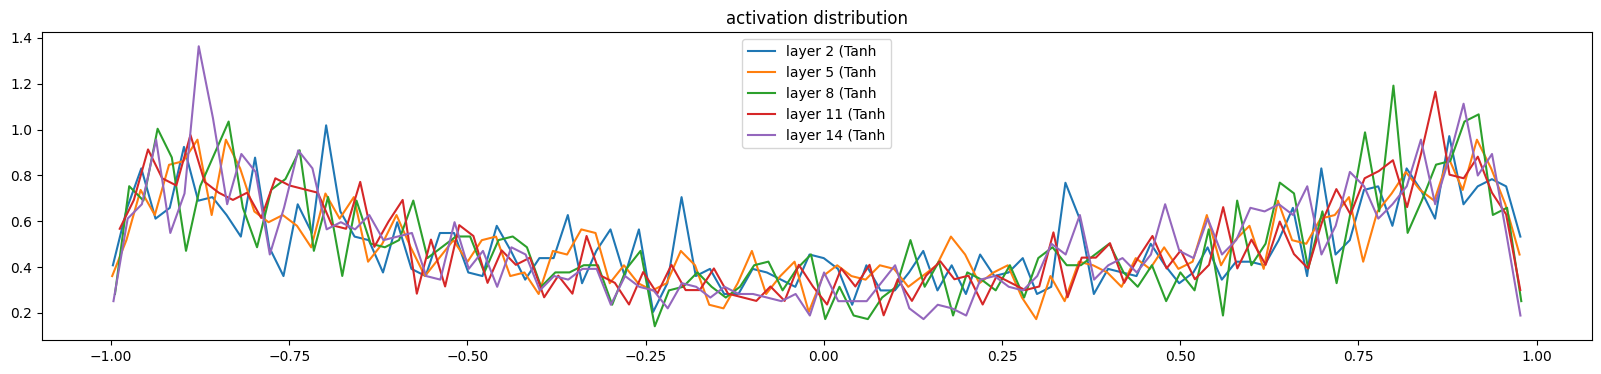

In [21]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

very small region is above saturation the reason is the gain is set to 5/3. 

layer 2 (      Tanh): mean -0.000000, std 2.392666e-03
layer 5 (      Tanh): mean -0.000000, std 2.155367e-03
layer 8 (      Tanh): mean -0.000000, std 1.901261e-03
layer 11 (      Tanh): mean +0.000000, std 1.653390e-03
layer 14 (      Tanh): mean +0.000000, std 1.544710e-03


Text(0.5, 1.0, 'gradient distribution')

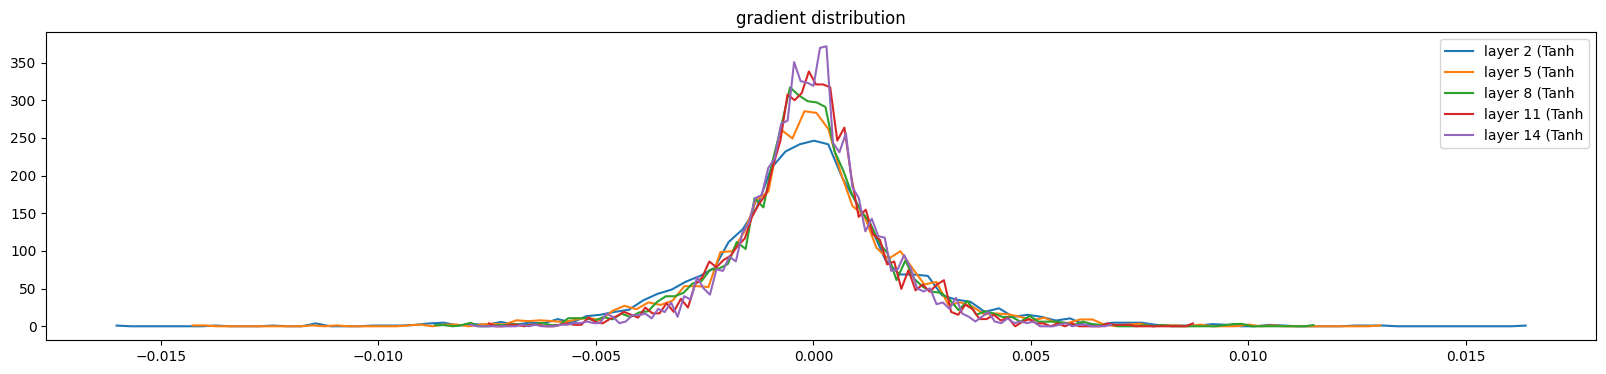

In [22]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 7.687083e-03 | grad:data ratio 7.679292e-03
weight  (30, 100) | mean +0.000053 | std 9.651603e-03 | grad:data ratio 5.127617e-02
weight (100, 100) | mean -0.000101 | std 6.765993e-03 | grad:data ratio 6.531678e-02
weight (100, 100) | mean +0.000005 | std 6.180673e-03 | grad:data ratio 6.070777e-02
weight (100, 100) | mean -0.000012 | std 5.178587e-03 | grad:data ratio 5.114772e-02
weight (100, 100) | mean -0.000027 | std 4.637808e-03 | grad:data ratio 4.634398e-02
weight  (100, 27) | mean +0.000027 | std 8.888344e-03 | grad:data ratio 8.502699e-02


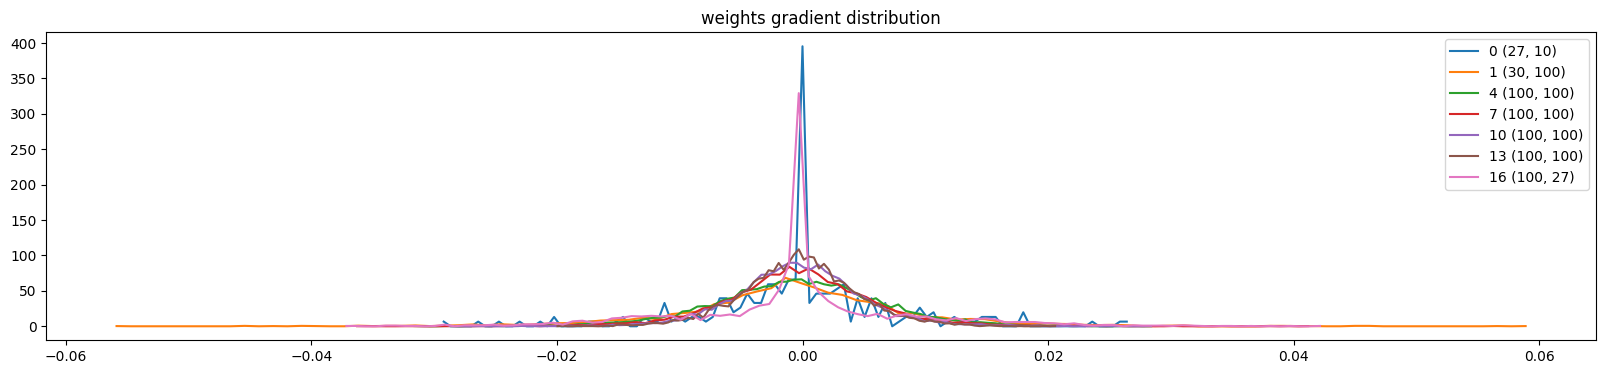

In [23]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

if the gradient are too large or too small, it's bad. last layer takes much larger value

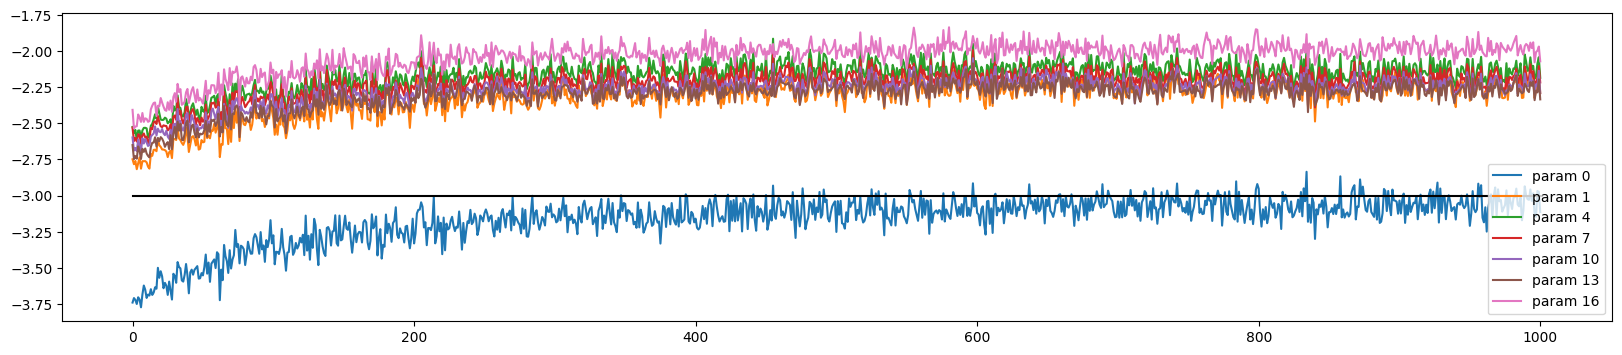

In [24]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
